## Requirements:
- creds JSON (mineria-2022.json).
- GEOJSON with Colombia's departments (colombia.geojson).

# Modeling

###Setup

In [3]:
import pandas as pd
from google.oauth2 import service_account
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import os
import shutil
import geopandas as gpd
from matplotlib.patches import Patch

In [4]:
creds = service_account.Credentials.from_service_account_file('mineria-2022.json')
client = bigquery.Client(credentials=creds, project='pobreza-397214')

In [5]:
sql = "SELECT * FROM `pobreza-397214.hogares.hogares`"
df = client.query(sql).result().to_dataframe()

In [6]:
df.head()

,PERIODO,DIRECTORIO,SECUENCIA_ENCUESTA,SECUENCIA_P,P5010,P8526,P8530,fex_c,REGION,DEPARTAMENTO,...,atencion_integral,inasistencia_escolar,rezago_escolar,alfabetismo,logro_educativo,hacinamiento,pobre,fexp,ipm,FECHA
0,20220939,7814476,1,1,1,1,1,262.960187,6,5,...,0,0,0,0,0,0,0,262.960187,0.0,2022
1,20220939,7820516,1,1,1,1,1,1768.081603,6,5,...,0,0,0,0,0,0,0,3536.163206,0.0,2022
2,20220939,7854255,1,1,2,1,1,1663.385296,6,5,...,0,0,0,0,0,0,0,4990.155887,0.0,2022
3,20220939,7859066,1,1,2,1,1,746.813426,6,5,...,0,0,0,0,0,0,0,2987.253706,0.0,2022
4,20220939,7874959,1,1,1,1,1,393.483850,6,5,...,0,0,0,0,0,0,0,393.483850,0.0,2022


###Data treatment

In [7]:
nombres_columnas = {
    'P5010': 'Número de Dormitorios',
    'P8526': 'Tipo de Servicio Sanitario',
    'P8530': 'Fuente Principal de Agua para Preparar Alimentos'
}

df.rename(columns=nombres_columnas, inplace=True)

In [8]:
departamentos = df['DEPARTAMENTO'].unique()
departamentos

<IntegerArray>
[ 5,  8, 11, 13, 15, 17, 18, 19, 20, 23, 25, 27, 41, 44, 47, 50, 52, 54, 63,
 66, 68, 70, 73, 76, 81, 85, 86, 88, 91, 94, 95, 97, 99]
Length: 33, dtype: Int64

<ipython-input-9-8574917d2c9c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


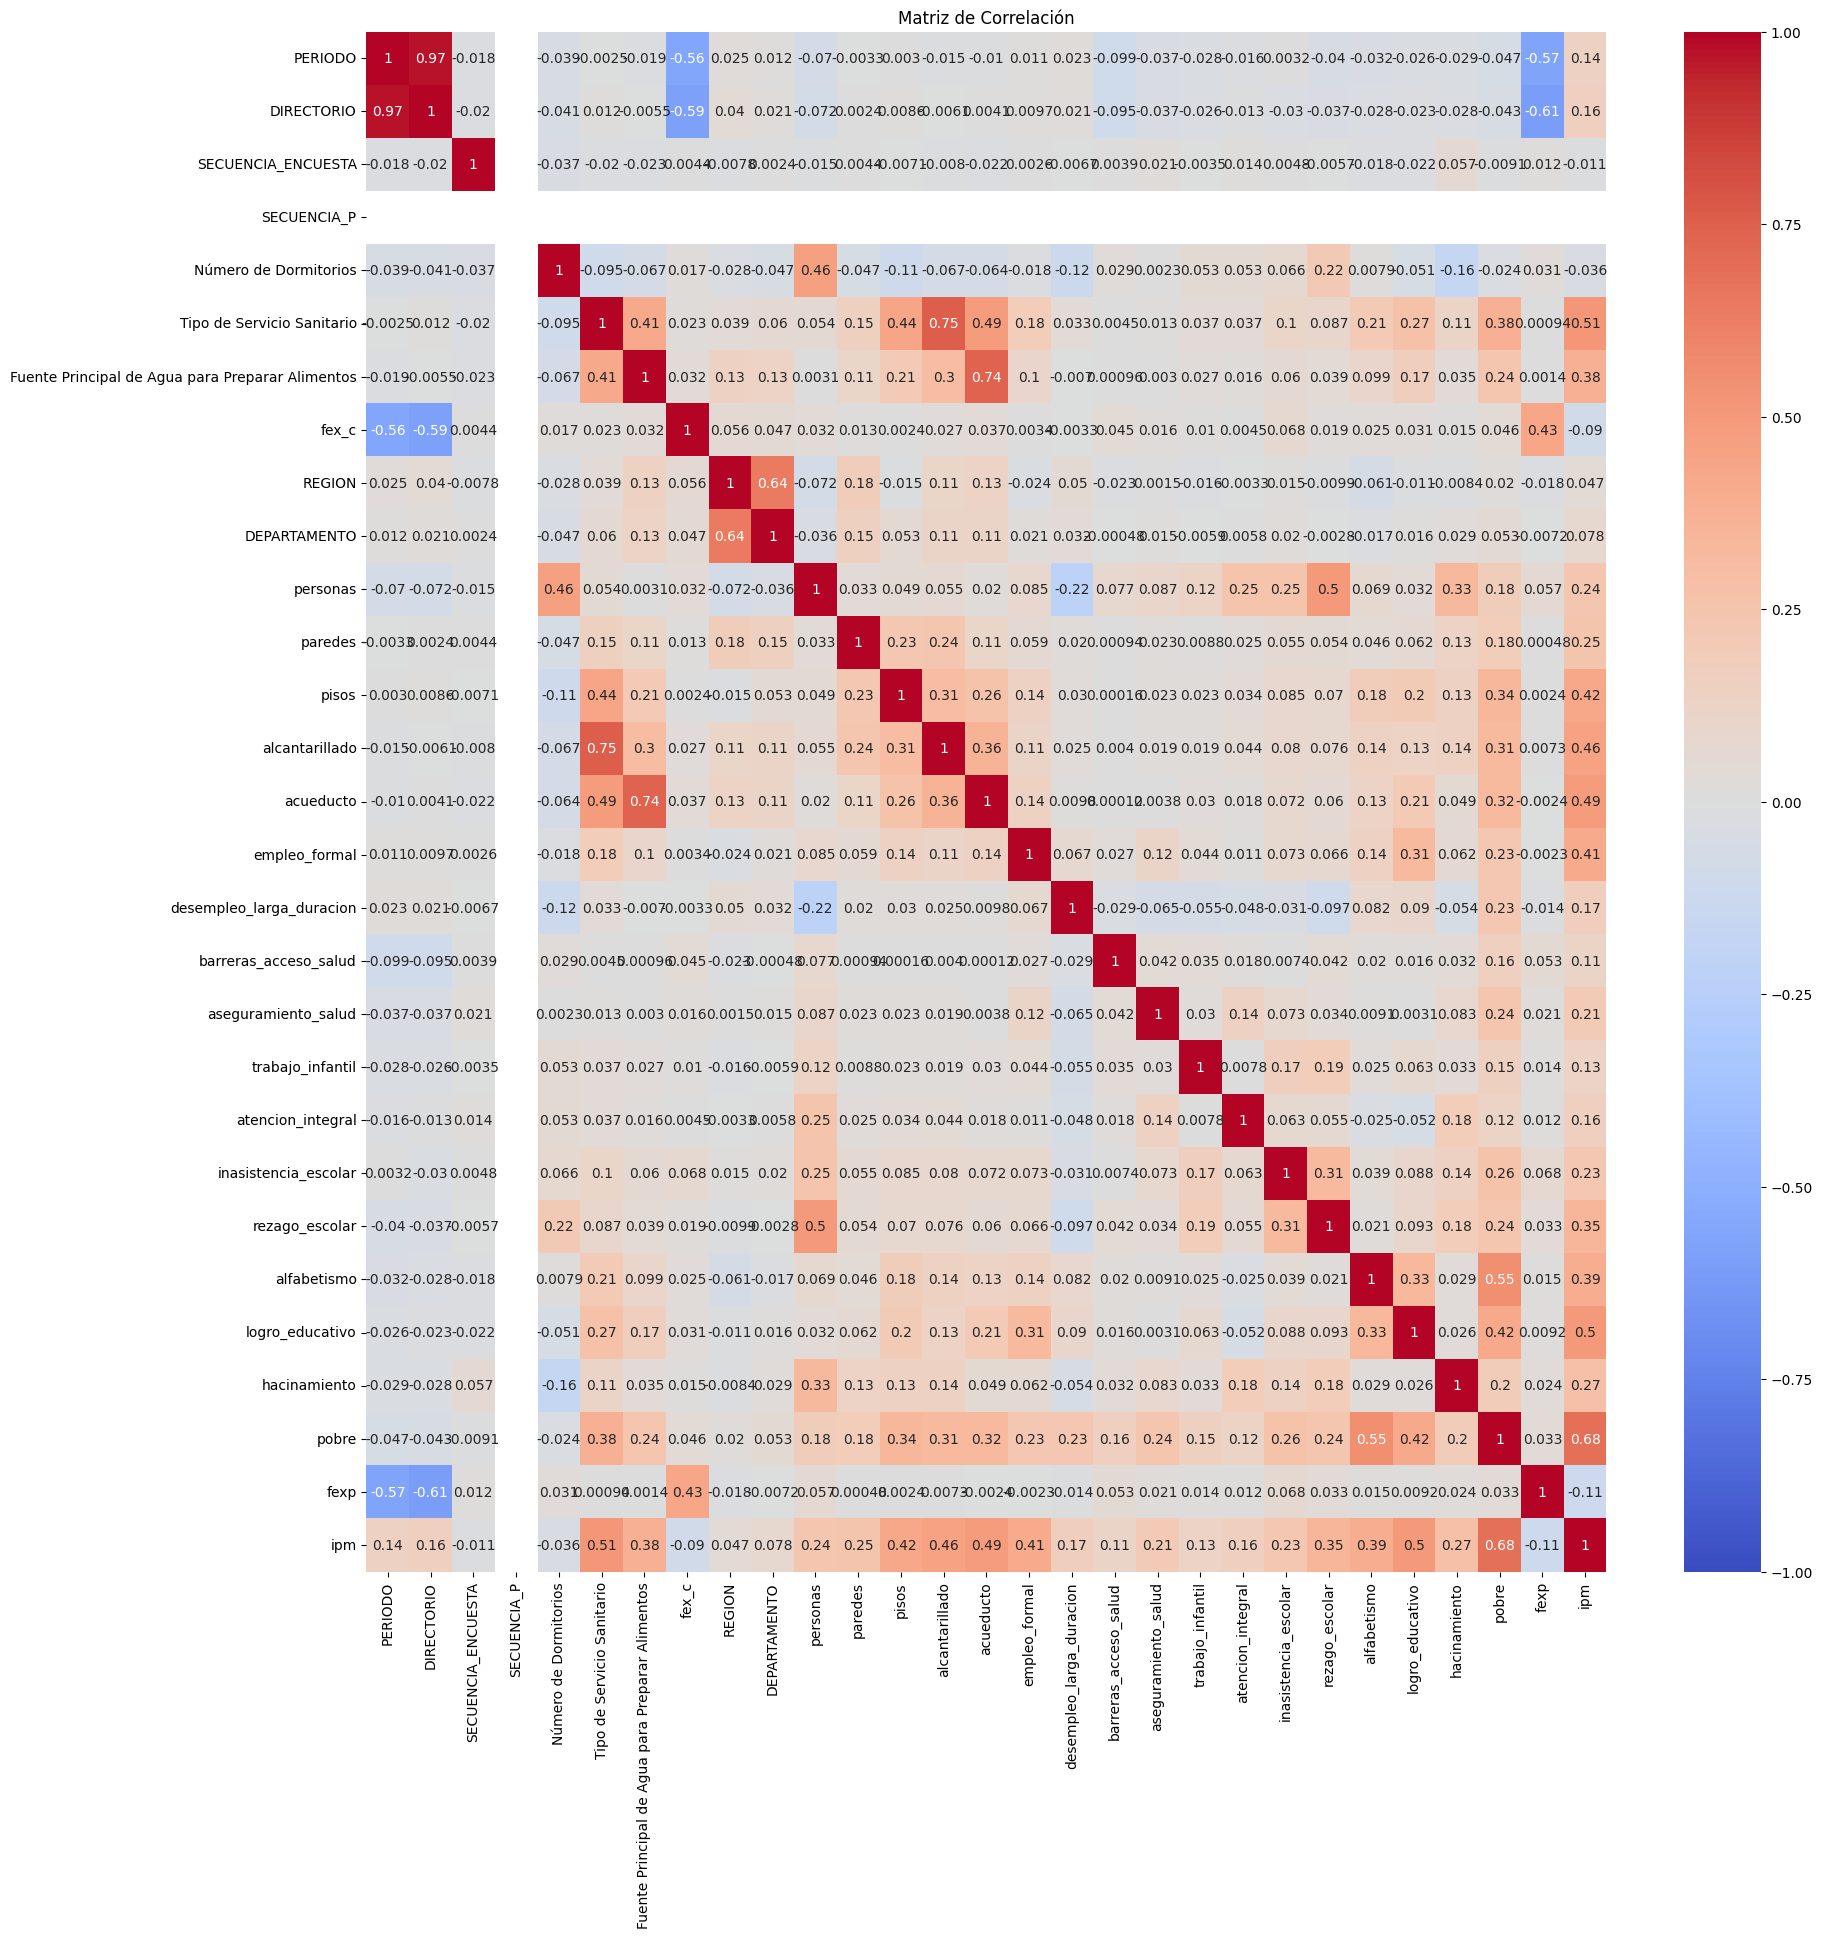

In [9]:
correlation_matrix = df.corr()

correlation_with_ipm = correlation_matrix['ipm']

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlación')
plt.show()

In [10]:
equivalencias_departamentos = {
    '91': 'Amazonas',
    '5': 'Antioquia',
    '81': 'Arauca',
    '8': 'Atlantico',
    '11': 'Bogota D.C.',
    '13': 'Bolivar',
    '15': 'Boyaca',
    '17': 'Caldas',
    '18': 'Caqueta',
    '85': 'Casanare',
    '19': 'Cauca',
    '20': 'Cesar',
    '27': 'Choco',
    '23': 'Cordoba',
    '25': 'Cundinamarca',
    '94': 'Guainia',
    '95': 'Guaviare',
    '41': 'Huila',
    '44': 'La Guajira',
    '47': 'Magdalena',
    '50': 'Meta',
    '52': 'Narino',
    '54': 'Norte de Santander',
    '86': 'Putumayo',
    '63': 'Quindio',
    '66': 'Risaralda',
    '88': 'San Andres',
    '68': 'Santander',
    '70': 'Sucre',
    '73': 'Tolima',
    '76': 'Valle del Cauca',
    '97': 'Vaupes',
    '99': 'Vichada'
}

###Model training

In [17]:
shutil.rmtree('modelos', ignore_errors=True)
os.makedirs('modelos', exist_ok=True)

variables_significativas = []
scores = []

inputs = ['logro_educativo', 'alfabetismo', 'rezago_escolar', 'inasistencia_escolar', 'atencion_integral',
          'trabajo_infantil', 'aseguramiento_salud', 'barreras_acceso_salud', 'empleo_formal', 'desempleo_larga_duracion',
          'acueducto', 'alcantarillado', 'pisos', 'paredes', 'hacinamiento']

for departamento in departamentos:
    df_departamento = df[df['DEPARTAMENTO'] == departamento]

    X = df_departamento[inputs]
    y = df_departamento['ipm']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    nombre_departamento = equivalencias_departamentos.get(str(departamento), f'departamento_{departamento}')

    mse = mean_squared_error(y_test, y_pred)
    score = model.score(X_test, y_test)
    scores.append(score)

    print(f'MSE para {nombre_departamento}: {mse}')
    print(f'Score para {nombre_departamento}: {score}')

    variable_importante = X.columns[model.feature_importances_.argmax()]
    print(f'Variable más importante para {nombre_departamento}: {variable_importante}')
    variables_significativas.append((nombre_departamento, variable_importante))

    modelo_path = f'modelos/modelo_{nombre_departamento}.joblib'
    joblib.dump(model, modelo_path)

# Calcular y mostrar el promedio de los scores
promedio_scores = sum(scores) / len(scores)


MSE para Antioquia: 0.004107662461817009
Score para Antioquia: 0.8026134006465188
Variable más importante para Antioquia: logro_educativo
MSE para Atlantico: 0.003985272808338418
Score para Atlantico: 0.81583627283758
Variable más importante para Atlantico: logro_educativo
MSE para Bogota D.C.: 0.00396316177518964
Score para Bogota D.C.: 0.7115572349579713
Variable más importante para Bogota D.C.: empleo_formal
MSE para Bolivar: 0.002306886332574657
Score para Bolivar: 0.899063402814375
Variable más importante para Bolivar: logro_educativo
MSE para Boyaca: 0.005017386868046254
Score para Boyaca: 0.6994015620475482
Variable más importante para Boyaca: logro_educativo
MSE para Caldas: 0.004660221465578223
Score para Caldas: 0.7424657817965652
Variable más importante para Caldas: acueducto
MSE para Caqueta: 0.0038310707764700074
Score para Caqueta: 0.8142487912506305
Variable más importante para Caqueta: logro_educativo
MSE para Cauca: 0.004010201673522926
Score para Cauca: 0.817269353933

Score promedio de los modelos

In [20]:
print(f'\nPromedio de scores: {promedio_scores}')


Promedio de scores: 0.812716845426721


In [18]:
print('\nVariables más significativas por departamento:')
for departamento, variable in variables_significativas:
    print(f'{departamento}: {variable}')


Variables más significativas por departamento:
Antioquia: logro_educativo
Atlantico: logro_educativo
Bogota D.C.: empleo_formal
Bolivar: logro_educativo
Boyaca: logro_educativo
Caldas: acueducto
Caqueta: logro_educativo
Cauca: logro_educativo
Cesar: logro_educativo
Cordoba: pisos
Cundinamarca: logro_educativo
Choco: logro_educativo
Huila: logro_educativo
La Guajira: alcantarillado
Magdalena: logro_educativo
Meta: logro_educativo
Narino: acueducto
Norte de Santander: logro_educativo
Quindio: logro_educativo
Risaralda: logro_educativo
Santander: logro_educativo
Sucre: pisos
Tolima: acueducto
Valle del Cauca: logro_educativo
Arauca: pisos
Casanare: logro_educativo
Putumayo: logro_educativo
San Andres: empleo_formal
Amazonas: logro_educativo
Guainia: logro_educativo
Guaviare: logro_educativo
Vaupes: logro_educativo
Vichada: pisos


In [19]:
valores_unicos = set(tupla[1] for tupla in variables_significativas)
lista_valores_unicos = list(valores_unicos)
print(lista_valores_unicos)

['alcantarillado', 'acueducto', 'logro_educativo', 'empleo_formal', 'pisos']


###Download models

In [14]:
carpeta_a_comprimir = '/content/modelos'
archivo_zip_salida = '/content/modelos'

shutil.make_archive(archivo_zip_salida, 'zip', carpeta_a_comprimir)

'/content/modelos.zip'

#Display

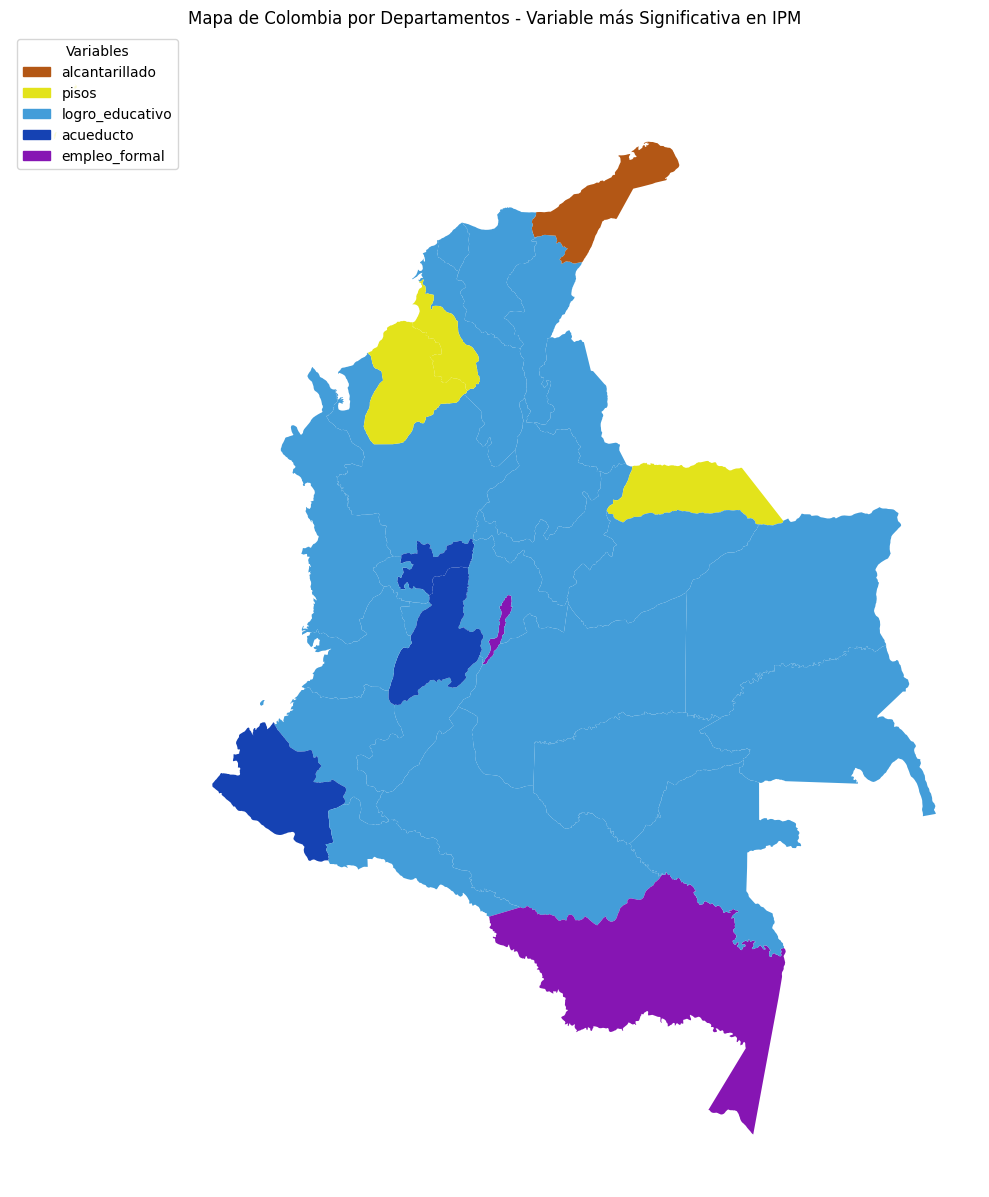

In [15]:
gdf = gpd.read_file('/content/colombia.geojson')

variables_color = {
    'alcantarillado': '#b35715',
    'pisos': '#e3e31b',
    'logro_educativo': '#439dd9',
    'acueducto': '#1542b3',
    'empleo_formal': '#8615b3'
}

colores = [variables_color[variable] for _, variable in variables_significativas]

fig, ax = plt.subplots(figsize=(15, 15))
gdf.plot(color=colores, legend=True, ax=ax)

legend_elements = [Patch(color=color, label=variable) for variable, color in variables_color.items()]
ax.legend(handles=legend_elements, title='Variables', loc='upper left')
ax.set_axis_off()
plt.title('Mapa de Colombia por Departamentos - Variable más Significativa en IPM')
plt.show()